In [1]:
# import cv2
# # import nanocamera as nano
# from IPython.display import display, Image
# import time
# import torch
# import torch.nn as nn
# from torchvision import models, transforms
# from PIL import Image as PILImage
# import torch.nn.functional as F
# import numpy as np
# import json

# # Initialize the camera NOTE: Uncomment this for jetson nano
# # camera = nano.Camera(camera_type=1, device_id=0, flip=1, width=320, height=240, fps=30)
# # display_handle = display(None, display_id=True)
# # print('USB Camera ready? - ', camera.isReady())

# # NOTE: Delete this later. Initialize the camera using OpenCV.
# camera = cv2.VideoCapture(0)
# camera.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
# camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
# display_handle = display(None, display_id=True)
# if not camera.isOpened():
#     print("Error: Could not open webcam.")
# else:
#     print('Webcam ready!')

# # Load class mappings from JSON file
# def load_class_mappings(file_path):
#     with open(file_path, 'r') as f:
#         class_mappings = json.load(f)
#     return class_mappings

# # Load the class mappings
# class_mappings_path = 'class_mappings.json'
# class_mappings = load_class_mappings(class_mappings_path)

# # Load model and checkpoint
# num_classes = 12
# checkpoint = './final_resnet34_cv.pth'
# model = models.resnet34(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model.load_state_dict(torch.load(checkpoint))
# # using gpu//////////
# model = model.to("cuda")

# # Define the transformations
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),  # Resize the image
#     transforms.ToTensor(),  # Convert the image to a PyTorch tensor
#     transforms.Normalize(mean=[0.436, 0.385, 0.345], std=[0.296, 0.270, 0.261])  # Normalize
# ])

# # Set model to evaluation mode
# model.eval()

# # Camera capture loop
# with torch.no_grad():
#     # while camera.isReady():
#     while camera.isOpened():
#         try:
#             # Read the camera image
#             # frame = camera.read()
#             ret, frame = camera.read()
#             if not ret:
#                 print("Failed to capture frame")
#                 break

#             # Convert to PIL Image for transformations
#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             # pil_image = PILImage.fromarray(frame_rgb)

#             # Apply transformations
#             transformed_frame = transform(frame_rgb).unsqueeze(0).to("cuda")

#             # Get the prediction
#             pred = model(transformed_frame)
            
#             # Apply softmax to get probabilities
#             probabilities = F.softmax(pred, dim=1)

#             # Get the predicted class and confidence score
#             pred_class = pred.argmax(1).item()
#             confidence = probabilities[0][pred_class].item()

#              # Get the class label from the class mappings
#             class_label = class_mappings[str(pred_class)] 

#             # Define the text and its properties
#             text = f'{class_label} ({confidence * 100:.2f}%)'

#             # Get the text size
#             text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]

#             # Put the text on the frame with a slight offset
#             cv2.putText(frame, text, (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 
#                         0.5, (0, 0, 255), 2, cv2.LINE_AA)

#             # Display the frame (convert back to JPEG format)
#             _, jpeg_frame = cv2.imencode('.jpeg', frame)
#             display_handle.update(Image(data=jpeg_frame.tobytes()))
#         except KeyboardInterrupt:
#             break

# # Clean up camera resources
# camera.release()
# cv2.destroyAllWindows()

## Salience Map Script

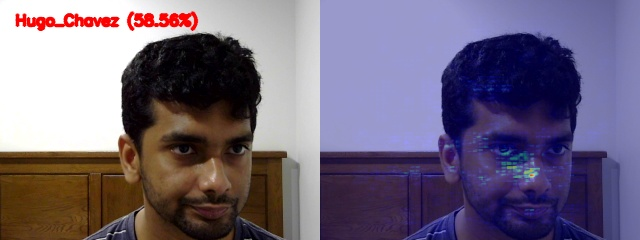

Webcam ready!


In [2]:
import cv2
from IPython.display import display, Image
import time
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image as PILImage
import torch.nn.functional as F
import numpy as np
import json

# Initialize the camera
camera = cv2.VideoCapture(0)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
display_handle = display(None, display_id=True)
if not camera.isOpened():
    print("Error: Could not open webcam.")
else:
    print('Webcam ready!')

# Load class mappings from JSON file
def load_class_mappings(file_path):
    with open(file_path, 'r') as f:
        class_mappings = json.load(f)
    return class_mappings

# Load the class mappings
class_mappings_path = 'class_mappings.json'
class_mappings = load_class_mappings(class_mappings_path)

# Load model and checkpoint
num_classes = 12
checkpoint = './final_resnet34_cv.pth'
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(checkpoint))
# using gpu//////////
model = model.to("cuda")

# Define the transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.436, 0.385, 0.345], std=[0.296, 0.270, 0.261])
])

# Set model to evaluation mode
# model.eval()

# Function to compute salience map
def compute_salience_map(input_tensor, predicted_class_index):
    input_tensor.requires_grad = True  # Enable gradients for the input tensor
    output = model(input_tensor)  # Forward pass
    model.zero_grad()  # Clear previous gradients

    # Backpropagate using the output for the predicted class
    output[0][predicted_class_index].backward()  # Backpropagate to get gradients
    salience = input_tensor.grad.data.abs()  # Get absolute gradients

    # Squeeze the salience to remove extra dimensions
    salience = salience.squeeze(0)  # Remove batch dimension
    salience = salience.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
    
    # Now take the maximum across the channel dimension to get a single channel
    salience = salience.max(dim=-1)[0]  # Take the max across the channel dimension

    salience = salience.cpu().numpy()  # Move to CPU and convert to numpy
    salience = np.maximum(salience, 0)  # Apply ReLU to get positive gradients

    # Normalize salience to [0, 1]
    salience = salience / salience.max() if salience.max() > 0 else salience
    
    # Scale to [0, 255] and convert to uint8
    salience = (salience * 255).astype(np.uint8)  # Ensure it is of type uint8

    return salience

model.eval()

# Camera capture loop
while camera.isOpened():
    try:
        ret, frame = camera.read()
        if not ret:
            print("Failed to capture frame")
            break

        # Convert to PIL Image for transformations
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Transform the frame and set requires_grad to True
        transformed_frame = transform(frame_rgb).unsqueeze(0).to("cuda")
        
        # Get the prediction
        pred = model(transformed_frame)
        probabilities = F.softmax(pred, dim=1)

        # Get the predicted class and confidence score
        pred_class = pred.argmax(1).item()
        confidence = probabilities[0][pred_class].item()
        class_label = class_mappings[str(pred_class)]

        # Define the text and its properties
        text = f'{class_label} ({confidence * 100:.2f}%)'
        
        # Compute the salience map
        salience_map = compute_salience_map(transformed_frame, pred_class)

        # Resize salience map to match the original frame size
        salience_map_resized = cv2.resize(salience_map, (frame.shape[1], frame.shape[0]))

        # Create a colored version of the salience map
        salience_colored = cv2.applyColorMap(salience_map_resized, cv2.COLORMAP_JET)

        # Overlay the salience map onto the original frame
        overlay = cv2.addWeighted(frame, 0.6, salience_colored, 0.4, 0)

        # Stack images for display
        combined = np.hstack((frame, overlay))
        cv2.putText(combined, text, (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 0, 255), 2, cv2.LINE_AA)


        # Convert to JPEG format and update display
        _, jpeg_frame = cv2.imencode('.jpeg', combined)
        display_handle.update(Image(data=jpeg_frame.tobytes()))
    except KeyboardInterrupt:
        break


# Clean up camera resources
camera.release()
cv2.destroyAllWindows()